# Generating DB

To make our lives easier, we'll use [DuckDBs TPCH extension](https://duckdb.org/docs/extensions/tpch.html) to generate everything in chunks. Let's start with a ~100GB database.

In [37]:
import datetime
import duckdb
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import pandas as pd
import seaborn as sns
import time

from tqdm.auto import tqdm

In [2]:
con = duckdb.connect(database="tpch_sf100.db")

In [ ]:
# con.execute("INSTALL tpch; LOAD tpch")
# for idx in tqdm(range(10)):
#     con.execute(f"CALL dbgen(sf=100, children=10, step={idx})")

# TPCH Query 3

```sql
SELECT
    l_orderkey,
    sum(l_extendedprice * (1 - l_discount)) as revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < date '1995-03-15'
    AND l_shipdate > date '1995-03-15'
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue desc,
    o_orderdate
LIMIT 20;
```

In this instance we will be changing `o_orderdate` and `l_shipdate` predicates

In [4]:
query_template = """
    SELECT
        l_orderkey,
        sum(l_extendedprice * (1 - l_discount)) as revenue,
        o_orderdate,
        o_shippriority
    FROM
        customer,
        orders,
        lineitem
    WHERE
        c_mktsegment = 'BUILDING'
        AND c_custkey = o_custkey
        AND l_orderkey = o_orderkey
        AND o_orderdate < $orderdate
        AND l_shipdate > $shipdate
    GROUP BY
        l_orderkey,
        o_orderdate,
        o_shippriority
    ORDER BY
        revenue desc,
        o_orderdate
    LIMIT 20;
"""

Query the database to find the maximum and minimum values for both `o_orderdate` and `l_shipdate`, we will set a specific amount of days we want to sweep over.

In [7]:
def daterange(start_date: datetime.date, end_date: datetime.date, day_jumps=1):
    total_days = int((end_date - start_date).days)
    return (start_date + datetime.timedelta(n) for n in range(0, total_days, day_jumps))

In [5]:
min_orderdate = con.sql("SELECT MIN(o_orderdate) FROM orders").fetchone()[0]
max_orderdate = con.sql("SELECT MAX(o_orderdate) FROM orders").fetchone()[0]
(min_orderdate, max_orderdate)

(datetime.date(1992, 1, 1), datetime.date(1998, 8, 2))

In [6]:
min_shipdate = con.sql("SELECT MIN(l_shipdate) FROM lineitem").fetchone()[0]
max_shipdate = con.sql("SELECT MAX(l_shipdate) FROM lineitem").fetchone()[0]
(min_shipdate, max_shipdate)

(datetime.date(1992, 1, 2), datetime.date(1998, 12, 1))

In [ ]:
# table = []
# for orderdate in tqdm(list(daterange(min_orderdate, max_orderdate, 30))):
#     for shipdate in tqdm(list(daterange(min_shipdate, max_shipdate, 30)), leave=False):
#         params = {'orderdate': orderdate, 'shipdate': shipdate}
#         start = time.time()
#         res = con.sql(query_template, params=params).explain()
#         elapsed = time.time() - start
#         params['elapsed'] = elapsed
#         table.append(params)

# table = pd.DataFrame(table)
# table

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

In [59]:
table.to_csv('tpch_q3_sweep.csv')

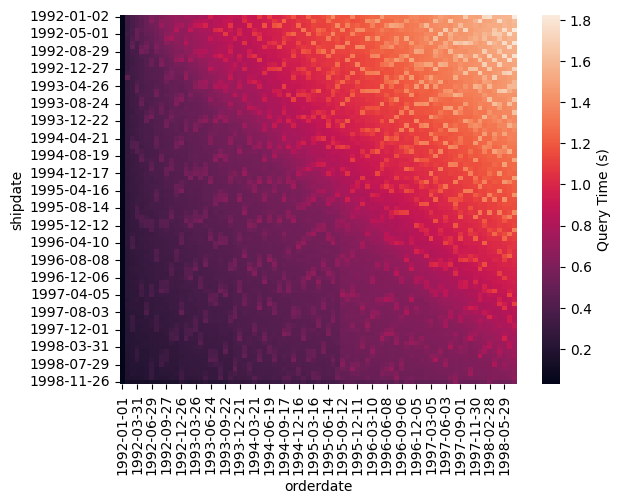

In [70]:
_ = sns.heatmap(table.pivot(index="shipdate", columns="orderdate", values="elapsed"), cbar_kws={'label': 'Query Time (s)'})

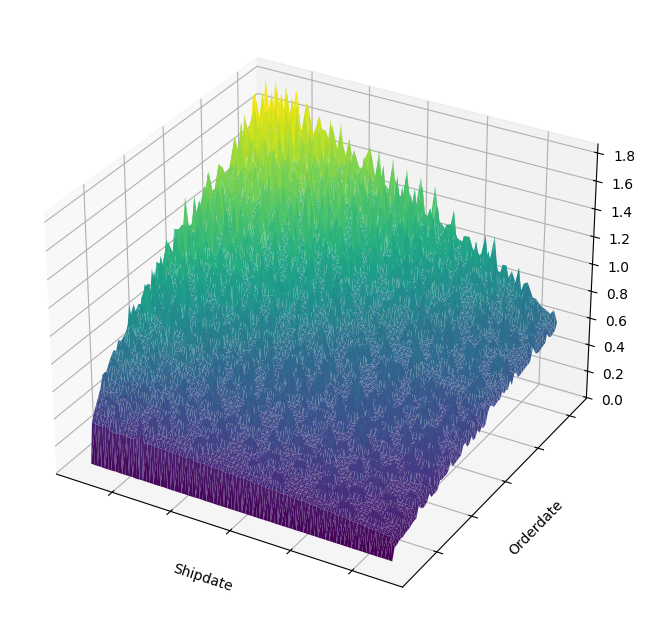

In [88]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(table['shipdate'].apply(lambda x: x.toordinal()), table['orderdate'].apply(lambda x: x.toordinal()), table['elapsed'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xticklabels([]), ax.set_yticklabels([])
ax.set_xlabel('Shipdate'), ax.set_ylabel('Orderdate')
plt.show()

In [106]:
table[(
    (table['orderdate'] < datetime.date(1994, 5, 1))
    & (table['orderdate'] > datetime.date(1994, 1, 1))
    & (table['shipdate'] < datetime.date(1994, 5, 1))
    & (table['shipdate'] > datetime.date(1994, 1, 1))
)]

,orderdate,shipdate,elapsed
2150,1994-01-20,1994-01-21,0.724578
2151,1994-01-20,1994-02-20,0.632512
2152,1994-01-20,1994-03-22,0.591362
2153,1994-01-20,1994-04-21,0.573951
2235,1994-02-19,1994-01-21,0.637598
2236,1994-02-19,1994-02-20,0.638566
2237,1994-02-19,1994-03-22,0.643436
2238,1994-02-19,1994-04-21,0.697929
2320,1994-03-21,1994-01-21,0.651623
2321,1994-03-21,1994-02-20,0.636559
